# ENI.MI - Algorithmic Trading Analysis

## Overview

This notebook demonstrates a complete algorithmic trading workflow using the **algoshort** library for **ENI S.p.A.** (ENI.MI), one of Italy's largest energy companies.

### Workflow Steps:
1. **Data Acquisition** - Download historical OHLC data from Yahoo Finance
2. **Relative Price Calculation** - Calculate performance relative to FTSE MIB benchmark
3. **Signal Generation** - Generate trading signals using multiple strategies
4. **Signal Combination** - Combine signals with entry/exit/direction logic
5. **Returns Calculation** - Calculate P&L and equity curves
6. **Stop Loss Calculation** - Implement risk management
7. **Position Sizing** - Determine optimal position sizes

### Key Concepts:
- **Relative Prices**: Stock performance vs. market benchmark (isolates alpha)
- **Regime Detection**: Identify bullish/bearish market conditions
- **Signal Combination**: Use direction + entry + exit logic for robust signals

---

## Configuration

### Ticker Settings

In [1]:
# =============================================================================
# TICKER CONFIGURATION
# =============================================================================
# Change these values to analyze a different stock

TICKER = "MONC.MI"           # Stock ticker symbol
BENCHMARK = "FTSEMIB.MI"    # Benchmark index for relative analysis
START_DATE = "2016-01-01"   # Start date for historical data
INITIAL_CAPITAL = 100000    # Starting capital for backtesting

### Imports and Logging Setup

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================
import logging
import pandas as pd
import numpy as np
from datetime import date
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# =============================================================================
# LOGGING CONFIGURATION
# =============================================================================
# Control verbosity of library output
# Options: DEBUG (verbose), INFO, WARNING (default), ERROR (quiet)
logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s [%(levelname)7s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

print("Imports completed successfully!")

Imports completed successfully!


---

## 1. Data Acquisition

### YFinanceDataHandler

The `YFinanceDataHandler` class provides:
- **Automatic caching** with parquet files (10-50x faster on repeated access)
- **Bulk downloads** with chunking to avoid rate limits
- **Data quality checks** and cleaning
- **Multiple output formats** (OHLC, wide, long)

**Key Methods:**
- `download_data()` - Download data for symbols
- `get_ohlc_data()` - Get formatted OHLC data
- `get_info()` - Get company fundamentals
- `list_available_data()` - Check data quality

In [3]:
# =============================================================================
# DATA DOWNLOAD
# =============================================================================
from algoshort.yfinance_handler import YFinanceDataHandler

# Initialize handler with caching enabled
# cache_dir: Where to store parquet files for faster future access
# enable_logging: Show download progress (set True for debugging)
# chunk_size: Symbols per batch (lower = less rate limiting)
handler = YFinanceDataHandler(
    cache_dir="./cache",
    enable_logging=False,
    chunk_size=30
)

# Download historical data for stock and benchmark
print(f"Downloading data for {TICKER} and {BENCHMARK}...")
print(f"Period: {START_DATE} to {date.today()}")

handler.download_data(
    symbols=[TICKER, BENCHMARK],
    start=START_DATE,
    end=date.today().isoformat(),
    interval='1d',      # Daily data
    use_cache=True      # Use cached data if available
)

print("\nDownload complete!")

Period: 2016-01-01 to 2026-02-10

Download complete!


In [4]:
# =============================================================================
# DATA QUALITY CHECK
# =============================================================================
print("Data Quality Summary:")
print("=" * 60)

summary = handler.list_available_data()
for symbol, info in summary.items():
    print(f"\n{symbol}:")
    print(f"  Rows: {info['rows']}")
    print(f"  Date Range: {info['date_range']}")
    print(f"  Missing Values: {info['missing_values']}")
    print(f"  Columns: {info['columns']}")

Data Quality Summary:

MONC.MI:
  Rows: 2567
  Date Range: 2016-01-04 to 2026-02-09
  Missing Values: 0
  Columns: ['open', 'high', 'low', 'close', 'volume']

FTSEMIB.MI:
  Rows: 2566
  Date Range: 2016-01-04 to 2026-02-09
  Missing Values: 0
  Columns: ['open', 'high', 'low', 'close', 'volume']


In [5]:
# =============================================================================
# GET OHLC DATA
# =============================================================================
# get_ohlc_data() returns a DataFrame with:
# - date: Trading date
# - open, high, low, close: OHLC prices

df = handler.get_ohlc_data(TICKER)
bmk = handler.get_ohlc_data(BENCHMARK)

# Add FX column (required for some calculations)
# Set to 1 for same currency (EUR in this case)
df['fx'] = 1

print(f"{TICKER} Data Shape: {df.shape}")
print(f"{BENCHMARK} Data Shape: {bmk.shape}")
print(f"\nDate Range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"\nFirst 5 rows:")
df.head()

MONC.MI Data Shape: (2567, 6)
FTSEMIB.MI Data Shape: (2566, 5)

Date Range: 2016-01-04 to 2026-02-09

First 5 rows:


,date,open,high,low,close,fx
0,2016-01-04,11.405756,11.405756,10.836358,11.076572,1
1,2016-01-05,11.210026,11.245613,10.809667,10.969810,1
2,2016-01-06,10.987604,11.014294,10.720699,10.845254,1
3,2016-01-07,10.569453,11.076573,10.053436,10.898636,1
4,2016-01-08,10.952017,11.094366,10.774079,10.987604,1


In [6]:
# =============================================================================
# COMPANY INFORMATION
# =============================================================================
# get_info() retrieves fundamental data from Yahoo Finance

info = handler.get_info(TICKER)

print(f"Company: {info.get('longName', 'N/A')}")
print(f"Sector: {info.get('sector', 'N/A')}")
print(f"Industry: {info.get('industry', 'N/A')}")
print(f"Market Cap: €{info.get('marketCap', 0):,.0f}")
print(f"P/E Ratio: {info.get('trailingPE', 'N/A')}")
print(f"Dividend Yield: {info.get('dividendYield', 0)*100:.2f}%" if info.get('dividendYield') else "Dividend Yield: N/A")

Company: Moncler S.p.A.
Sector: Consumer Cyclical
Industry: Apparel Manufacturing
Market Cap: €13,791,761,408
P/E Ratio: 22.469027
Dividend Yield: 262.00%


---

## 2. Relative Price Calculation

### OHLCProcessor

**Why Relative Prices?**

Relative prices show how a stock performs **compared to the market**:
- **Absolute Price**: ENI goes up 5% → Could be market rally (beta)
- **Relative Price**: ENI goes up 5% vs market 2% → Stock outperforms (alpha)

This helps:
- Isolate stock-specific performance from market movements
- Identify true outperformers/underperformers
- Build market-neutral strategies

**Calculation:**
```
Relative Price = Stock Price / Benchmark Price (rebased to 1.0)
```

In [7]:
# =============================================================================
# CALCULATE RELATIVE PRICES
# =============================================================================
from algoshort.ohlcprocessor import OHLCProcessor

# Initialize processor
processor = OHLCProcessor()

# Calculate relative prices
# This divides each OHLC value by the benchmark, rebasing to 1.0 at start
df = processor.calculate_relative_prices(
    stock_data=df,
    benchmark_data=bmk,
    benchmark_column='close',  # Use benchmark close prices
    digits=4,                   # Decimal places for rounding
    rebase=True                 # Rebase benchmark to 1.0 at start
)

print("Relative OHLC columns created:")
print("  ropen  - Relative Open")
print("  rhigh  - Relative High")
print("  rlow   - Relative Low")
print("  rclose - Relative Close")
print(f"\nDataFrame shape: {df.shape}")

2026-02-10 21:33:03 [WARNING] algoshort.ohlcprocessor.OHLCProcessor: Missing benchmark data for 1 rows (0.0%). Values will be forward-filled. This may indicate misaligned date ranges.


Relative OHLC columns created:
  ropen  - Relative Open
  rhigh  - Relative High
  rlow   - Relative Low
  rclose - Relative Close

DataFrame shape: (2567, 10)


In [8]:
df.head()

,date,open,high,low,close,fx,ropen,rhigh,rlow,rclose
0,2016-01-04,11.405756,11.405756,10.836358,11.076572,1,11.4058,11.4058,10.8364,11.0766
1,2016-01-05,11.210026,11.245613,10.809667,10.969810,1,11.0770,11.1122,10.6814,10.8396
2,2016-01-06,10.987604,11.014294,10.720699,10.845254,1,11.1555,11.1826,10.8845,11.0109
3,2016-01-07,10.569453,11.076573,10.053436,10.898636,1,10.8548,11.3756,10.3248,11.1928
4,2016-01-08,10.952017,11.094366,10.774079,10.987604,1,11.4288,11.5774,11.2431,11.4660


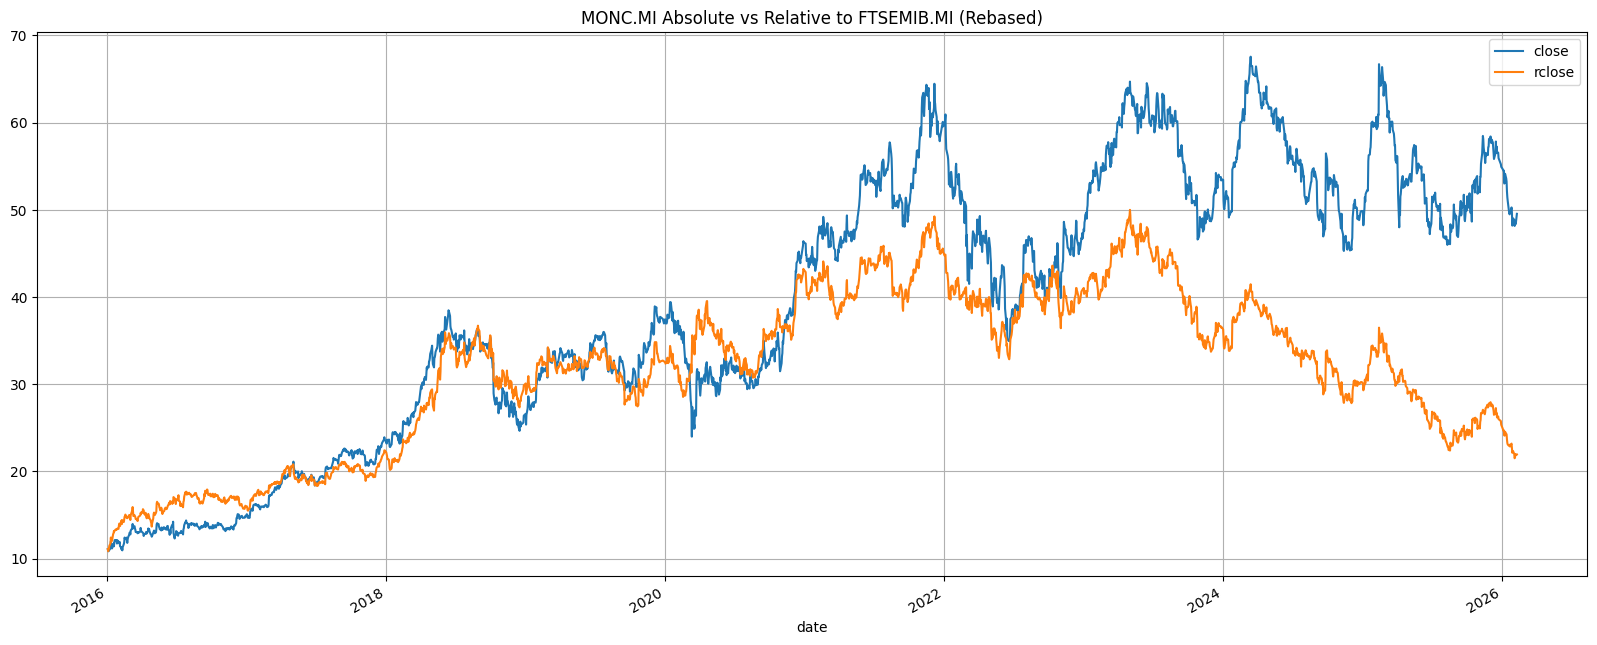

In [9]:

from plots import TradingVisualizer
viz = TradingVisualizer(figsize=(20, 8), grid=True)
viz.plot_abs_rel(
    df=df,
    ticker=TICKER,
    bm_name=BENCHMARK
)

In [10]:
# =============================================================================
# COMPARE ABSOLUTE VS RELATIVE PRICES
# =============================================================================
print("Absolute vs Relative Close Prices:")
print("=" * 60)
print(df[['date', 'close', 'rclose']].head(10).to_string(index=False))

# Calculate correlation
corr = df['close'].corr(df['rclose'])
print(f"\nCorrelation between absolute and relative: {corr:.4f}")
print(f"→ Lower correlation = more diversification benefit")

Absolute vs Relative Close Prices:
      date     close  rclose
2016-01-04 11.076572 11.0766
2016-01-05 10.969810 10.8396
2016-01-06 10.845254 11.0109
2016-01-07 10.898636 11.1928
2016-01-08 10.987604 11.4660
2016-01-11 11.174438 11.7276
2016-01-12 11.957360 12.4148
2016-01-13 11.628178 11.9711
2016-01-14 11.476931 12.0165
2016-01-15 11.156643 12.0505

Correlation between absolute and relative: 0.7856
→ Lower correlation = more diversification benefit


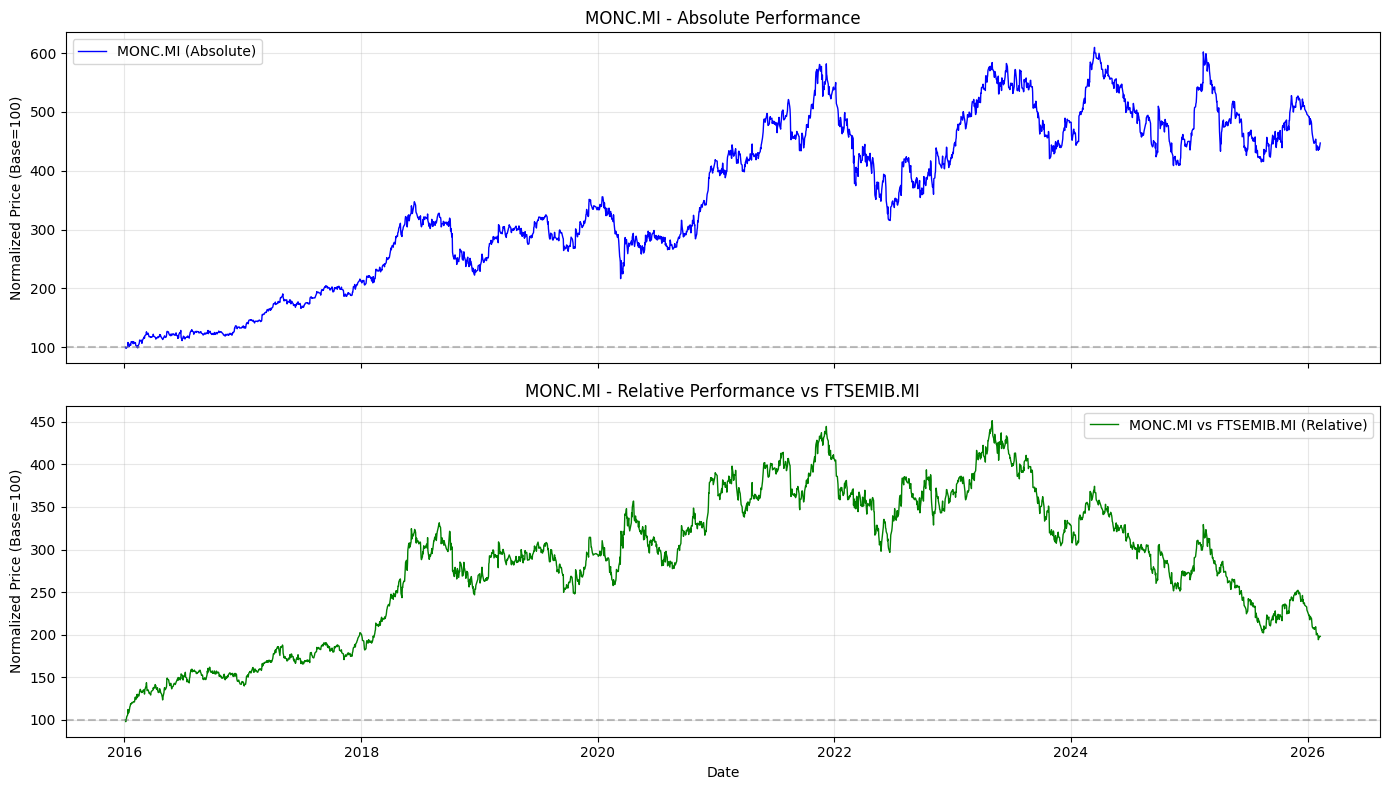


Performance Summary:
  Absolute Return: +347.16%
  Relative Return (vs benchmark): +98.01%
  Alpha (outperformance): +98.01%


In [11]:
# =============================================================================
# VISUALIZE ABSOLUTE VS RELATIVE PERFORMANCE
# =============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Normalize both to 100 at start for comparison
abs_normalized = (df['close'] / df['close'].iloc[0]) * 100
rel_normalized = (df['rclose'] / df['rclose'].iloc[0]) * 100

# Plot absolute price
axes[0].plot(df['date'], abs_normalized, 'b-', linewidth=1, label=f'{TICKER} (Absolute)')
axes[0].axhline(y=100, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Normalized Price (Base=100)')
axes[0].set_title(f'{TICKER} - Absolute Performance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot relative price
axes[1].plot(df['date'], rel_normalized, 'g-', linewidth=1, label=f'{TICKER} vs {BENCHMARK} (Relative)')
axes[1].axhline(y=100, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Normalized Price (Base=100)')
axes[1].set_xlabel('Date')
axes[1].set_title(f'{TICKER} - Relative Performance vs {BENCHMARK}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print performance summary
abs_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
rel_return = (df['rclose'].iloc[-1] / df['rclose'].iloc[0] - 1) * 100
print(f"\nPerformance Summary:")
print(f"  Absolute Return: {abs_return:+.2f}%")
print(f"  Relative Return (vs benchmark): {rel_return:+.2f}%")
print(f"  Alpha (outperformance): {rel_return:+.2f}%")

---

## 3. Signal Generation

### Trading Signals Overview

We generate signals using three different regime detection methods:

| Method | Class | Description |
|--------|-------|-------------|
| **Breakout** | `RegimeBO` | Price breaks above/below N-day high/low |
| **Turtle Trader** | `RegimeBO` | Dual-window breakout system |
| **MA Crossover** | `TripleMACrossoverRegime` | Triple moving average alignment |
| **Floor/Ceiling** | `RegimeFC` | Swing-based regime detection |

**Signal Values:**
- `1` = Bullish / Long
- `0` = Neutral / Flat
- `-1` = Bearish / Short

### 3.1 Breakout Signals (RegimeBO)

**Breakout Logic:**
- **Long (1)**: Price makes new N-day high
- **Short (-1)**: Price makes new N-day low

Simple but effective trend-following approach.

In [12]:
# =============================================================================
# BREAKOUT SIGNALS
# =============================================================================
from algoshort.regime_bo import RegimeBO

# Initialize with OHLC data
regime_bo = RegimeBO(ohlc_stock=df)

# Generate breakout signals for different windows
# Shorter windows = more signals, faster reaction
# Longer windows = fewer signals, more reliable trends
breakout_windows = [20, 50, 100]

print("Generating Breakout Signals:")
print("=" * 60)

for window in breakout_windows:
    df = regime_bo.compute_regime(
        regime_type='breakout',  # Single window breakout
        window=window,           # Lookback period
        relative=True,           # Use relative prices (ropen, rhigh, etc.)
        inplace=True             # Modify df in place
    )
    
    # Count signal distribution
    signal_col = f'rbo_{window}'
    counts = df[signal_col].value_counts().to_dict()
    print(f"\n  rbo_{window} ({window}-day breakout):")
    print(f"    Long (1):  {counts.get(1.0, 0):>5} bars ({counts.get(1.0, 0)/len(df)*100:.1f}%)")
    print(f"    Short (-1): {counts.get(-1.0, 0):>5} bars ({counts.get(-1.0, 0)/len(df)*100:.1f}%)")

Generating Breakout Signals:

  rbo_20 (20-day breakout):
    Long (1):   1257 bars (49.0%)
    Short (-1):  1289 bars (50.2%)

  rbo_50 (50-day breakout):
    Long (1):   1346 bars (52.4%)
    Short (-1):  1141 bars (44.4%)

  rbo_100 (100-day breakout):
    Long (1):   1615 bars (62.9%)
    Short (-1):   839 bars (32.7%)


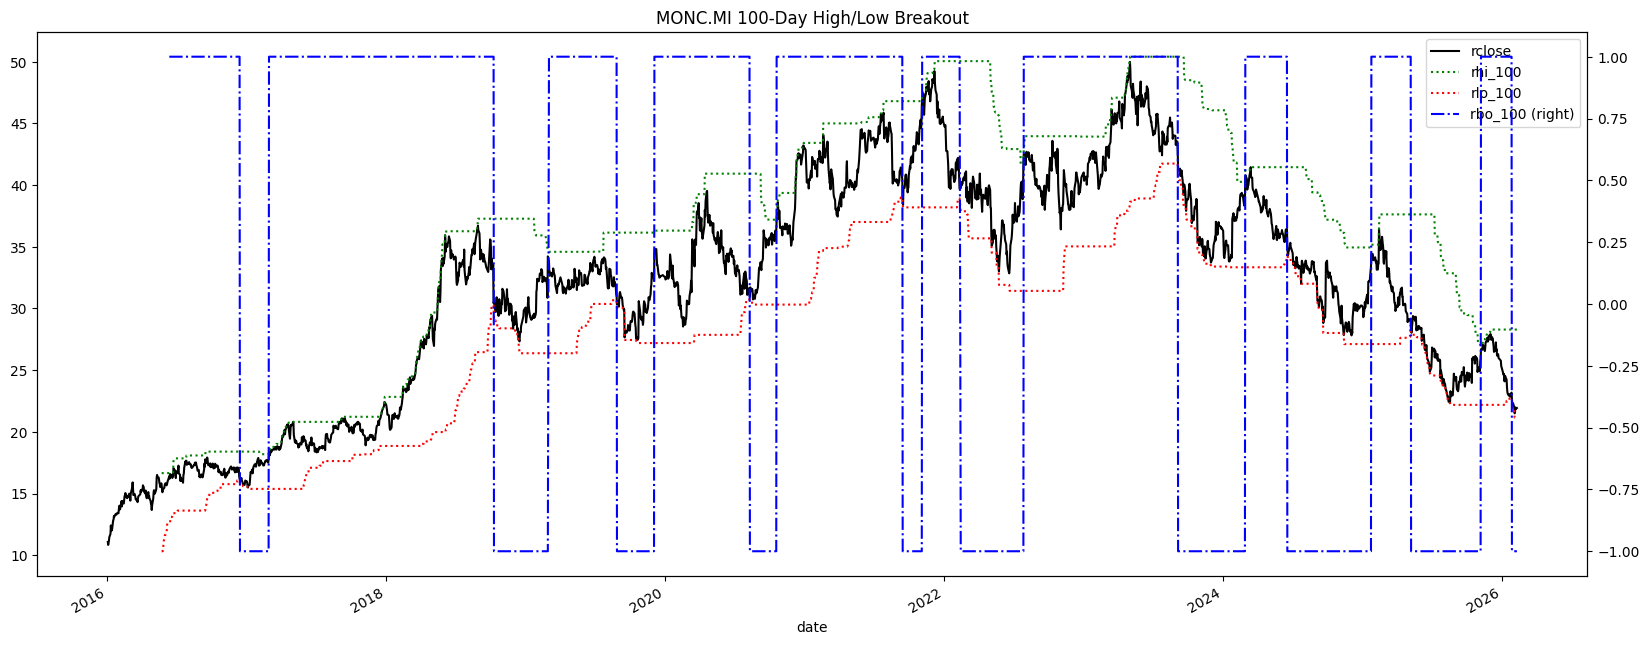

In [13]:
viz.plot_signal_bo(
    df=df,
    window=100,
    ticker=TICKER,
    relative=True
)

### 3.2 Turtle Trader Signals

**Turtle Trader Logic:**
- **Entry**: On slow window (e.g., 50-day) breakout
- **Exit**: On fast window (e.g., 20-day) breakout in opposite direction

More conservative than simple breakout - requires both entry and exit confirmation.

In [14]:
# =============================================================================
# TURTLE TRADER SIGNALS
# =============================================================================
# Turtle Trader uses two windows:
# - Slow window: For entry signals (longer, more reliable)
# - Fast window: For exit signals (shorter, quicker exit)

turtle_params = [
    {'fast': 20, 'slow': 50},   # Classic Turtle Trader
]

print("Generating Turtle Trader Signals:")
print("=" * 60)

for params in turtle_params:
    fast, slow = params['fast'], params['slow']
    
    df = regime_bo.compute_regime(
        regime_type='turtle',    # Dual window system
        window=slow,             # Slow (entry) window
        fast_window=fast,        # Fast (exit) window
        relative=True,
        inplace=True
    )
    
    signal_col = f'rtt_{slow}{fast}'
    counts = df[signal_col].value_counts().to_dict()
    print(f"\n  rtt_{slow}{fast} (Slow={slow}, Fast={fast}):")
    print(f"    Long (1):   {counts.get(1, 0):>5} bars ({counts.get(1, 0)/len(df)*100:.1f}%)")
    print(f"    Neutral (0): {counts.get(0, 0):>5} bars ({counts.get(0, 0)/len(df)*100:.1f}%)")
    print(f"    Short (-1): {counts.get(-1, 0):>5} bars ({counts.get(-1, 0)/len(df)*100:.1f}%)")

Generating Turtle Trader Signals:

  rtt_5020 (Slow=50, Fast=20):
    Long (1):     955 bars (37.2%)
    Neutral (0):   738 bars (28.7%)
    Short (-1):   874 bars (34.0%)


In [15]:
df.head()

,date,open,high,low,close,fx,ropen,rhigh,rlow,rclose,rhi_20,rlo_20,rbo_20,rhi_50,rlo_50,rbo_50,rhi_100,rlo_100,rbo_100,rtt_5020
0,2016-01-04,11.405756,11.405756,10.836358,11.076572,1,11.4058,11.4058,10.8364,11.0766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2016-01-05,11.210026,11.245613,10.809667,10.969810,1,11.0770,11.1122,10.6814,10.8396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2016-01-06,10.987604,11.014294,10.720699,10.845254,1,11.1555,11.1826,10.8845,11.0109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2016-01-07,10.569453,11.076573,10.053436,10.898636,1,10.8548,11.3756,10.3248,11.1928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2016-01-08,10.952017,11.094366,10.774079,10.987604,1,11.4288,11.5774,11.2431,11.4660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


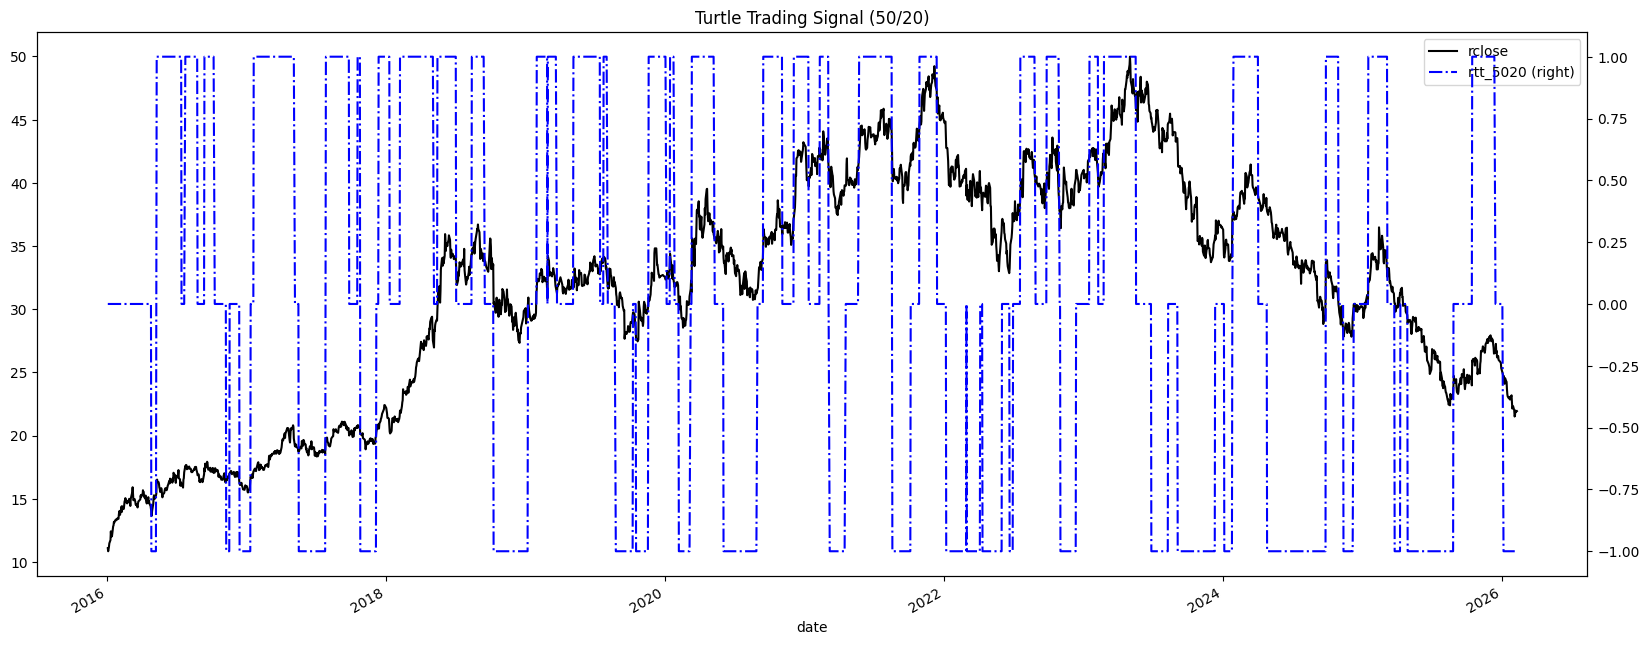

In [16]:
viz.plot_signal_tt(
    df=df,
    fast=20,
    slow=50,
    relative=True,
)

### 3.3 Moving Average Crossover Signals

**Triple MA Logic:**
- Uses three MAs: Short, Medium, Long
- **Bullish (1)**: Short > Medium > Long (uptrend alignment)
- **Bearish (-1)**: Short < Medium < Long (downtrend alignment)
- **Neutral (0)**: Mixed alignment

Supports both SMA (Simple) and EMA (Exponential) moving averages.

In [17]:
# =============================================================================
# MOVING AVERAGE CROSSOVER SIGNALS
# =============================================================================
from algoshort.regime_ma import TripleMACrossoverRegime

# Initialize with OHLC data
regime_ma = TripleMACrossoverRegime(ohlc_stock=df)

# MA parameters
ma_params = {'short': 50, 'medium': 100, 'long': 150}

print("Generating MA Crossover Signals:")
print("=" * 60)
print(f"Parameters: Short={ma_params['short']}, Medium={ma_params['medium']}, Long={ma_params['long']}")

for ma_type in ['sma', 'ema']:
    df = regime_ma.compute_ma_regime(
        ma_type=ma_type,
        short_window=ma_params['short'],
        medium_window=ma_params['medium'],
        long_window=ma_params['long'],
        relative=True,
        inplace=True
    )
    
    signal_col = f"r{ma_type}_{ma_params['short']}{ma_params['medium']}{ma_params['long']}"
    counts = df[signal_col].value_counts().to_dict()
    print(f"\n  {signal_col} ({ma_type.upper()}):")
    print(f"    Long (1):  {counts.get(1.0, 0):>5} bars ({counts.get(1.0, 0)/len(df)*100:.1f}%)")
    print(f"    Short (-1): {counts.get(-1.0, 0):>5} bars ({counts.get(-1.0, 0)/len(df)*100:.1f}%)")

Generating MA Crossover Signals:
Parameters: Short=50, Medium=100, Long=150

  rsma_50100150 (SMA):
    Long (1):   1553 bars (60.5%)
    Short (-1):   865 bars (33.7%)

  rema_50100150 (EMA):
    Long (1):   2020 bars (78.7%)
    Short (-1):   398 bars (15.5%)


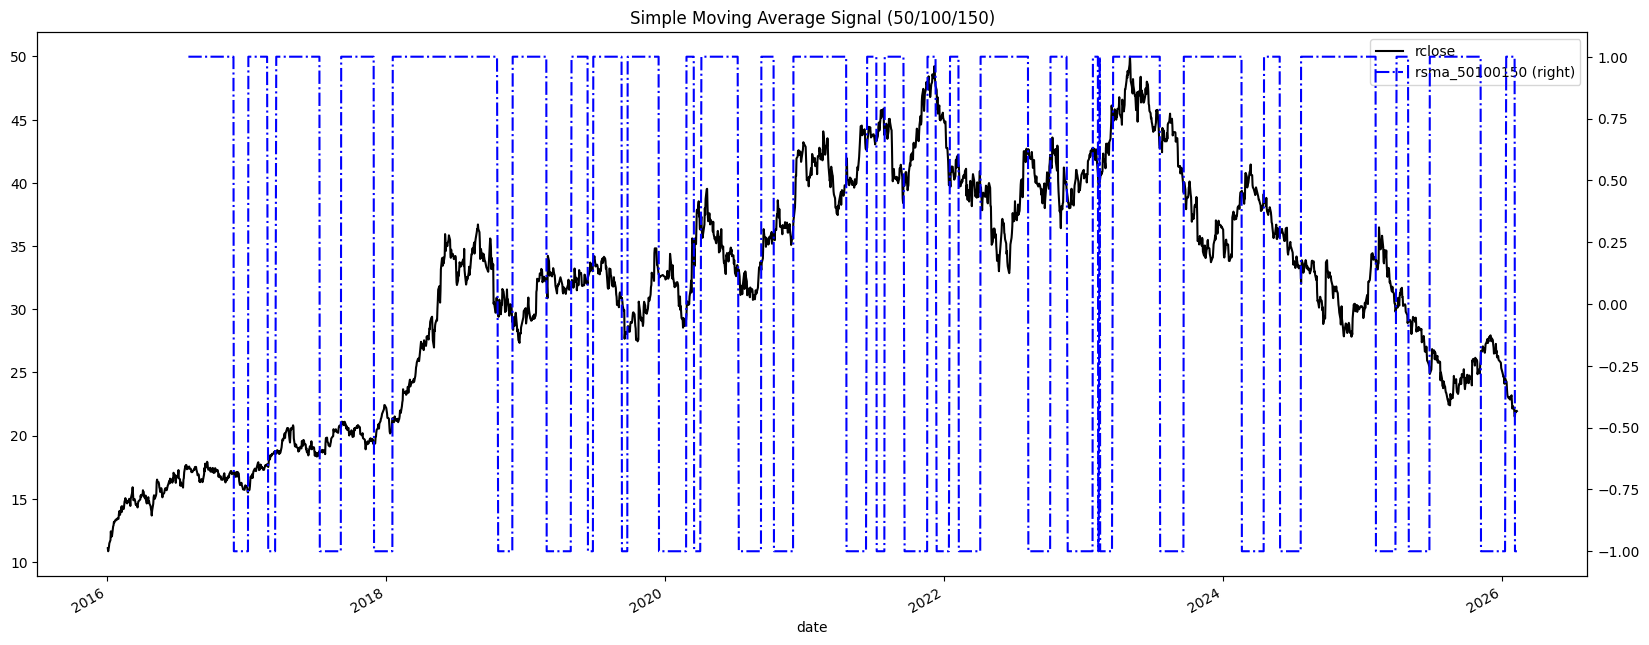

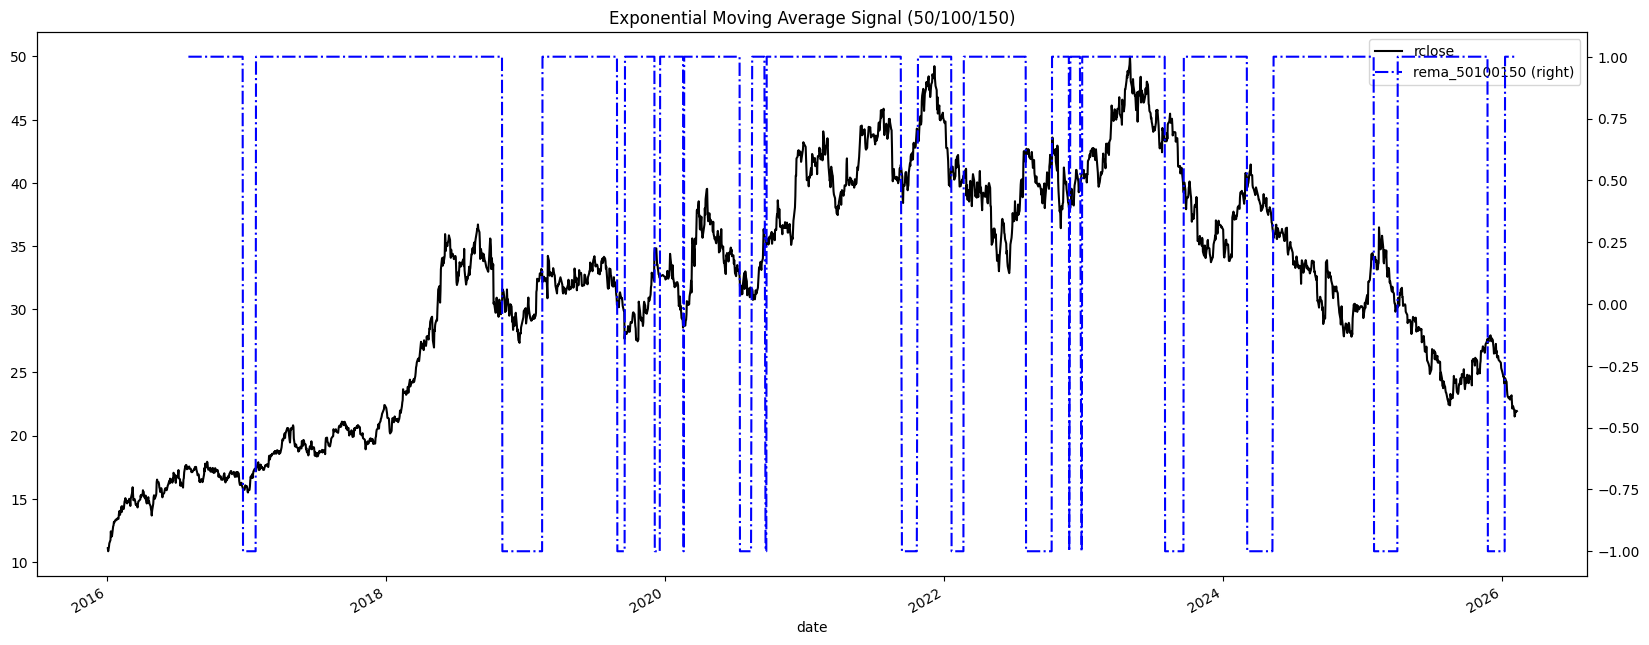

In [18]:
viz.plot_signal_ma(
    df=df,
    st=50,
    mt=100,
    lt=150, 
    relative=True,
)

### 3.4 Floor/Ceiling Regime Detection

**Floor/Ceiling Logic:**
- Sophisticated swing detection algorithm
- Identifies support (floor) and resistance (ceiling) levels
- Determines regime based on swing structure

This is used as the **direction filter** for combining signals.

In [19]:
# =============================================================================
# FLOOR/CEILING REGIME DETECTION
# =============================================================================
from algoshort.regime_fc import RegimeFC

# Initialize with OHLC data
# log_level=WARNING suppresses verbose output
regime_fc = RegimeFC(df=df, log_level=logging.WARNING)

print("Generating Floor/Ceiling Regime:")
print("=" * 60)

# Compute regime
df = regime_fc.compute_regime(
    relative=True,       # Use relative prices
    lvl=3,               # Swing level (higher = smoother)
    vlty_n=63,           # Volatility lookback (quarterly)
    threshold=0.05,      # Swing threshold (5%)
    dgt=3,               # Decimal places
    d_vol=1,             # Volume filter
    dist_pct=0.05,       # Distance percentage
    retrace_pct=0.05,    # Retracement percentage
    r_vol=1.0            # Relative volume
)

if 'rrg' in df.columns:
    counts = df['rrg'].value_counts().to_dict()
    print(f"\n  rrg (Floor/Ceiling Regime):")
    print(f"    Bullish (1):  {counts.get(1.0, 0):>5} bars ({counts.get(1.0, 0)/len(df)*100:.1f}%)")
    print(f"    Bearish (-1): {counts.get(-1.0, 0):>5} bars ({counts.get(-1.0, 0)/len(df)*100:.1f}%)")
else:
    print("  Warning: rrg column not created")

Generating Floor/Ceiling Regime:

  rrg (Floor/Ceiling Regime):
    Bullish (1):   1858 bars (72.4%)
    Bearish (-1):   168 bars (6.5%)


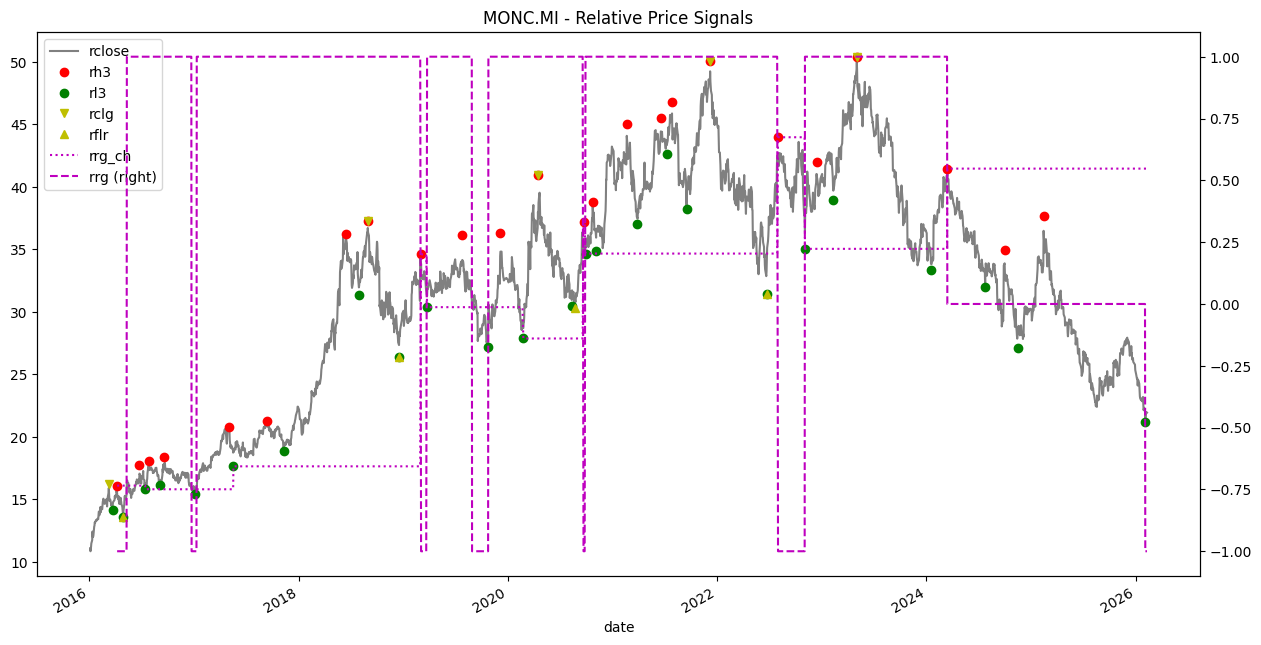

In [20]:
viz.plot_signal_rel(
    df=df, 
    ticker=TICKER,
)

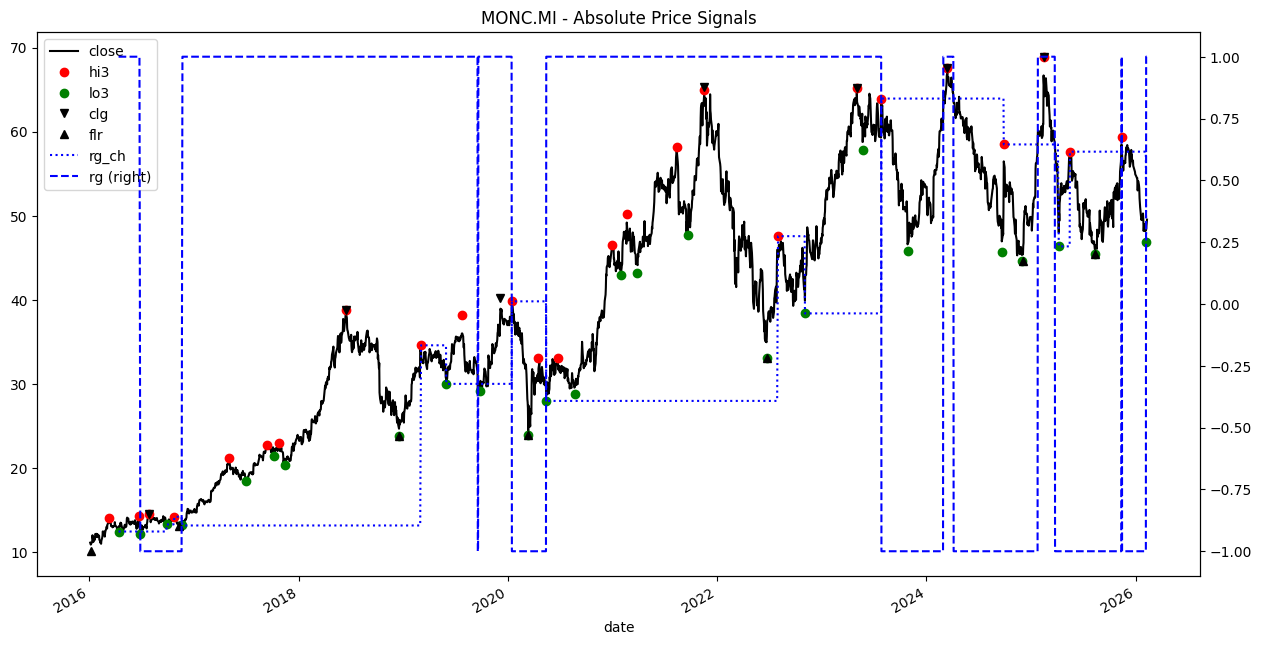

In [21]:
df = regime_fc.compute_regime(
    relative=False,       # Use relative prices
    lvl=3,               # Swing level (higher = smoother)
    vlty_n=63,           # Volatility lookback (quarterly)
    threshold=0.05,      # Swing threshold (5%)
    dgt=3,               # Decimal places
    d_vol=1,             # Volume filter
    dist_pct=0.05,       # Distance percentage
    retrace_pct=0.05,    # Retracement percentage
    r_vol=1.0            # Relative volume
)

viz.plot_signal_abs(
    df=df, 
    ticker=TICKER,
)

In [22]:
# =============================================================================
# SIGNAL SUMMARY
# =============================================================================
# Collect all signal columns
signal_columns = [col for col in df.columns
                  if any(col.startswith(prefix)
                         for prefix in ['rbo_', 'rtt_', 'rsma_', 'rema_', 'rrg'])
                  and not any(kw in col for kw in ['short', 'medium', 'long', '_ch'])]

# Remove 'rrg_ch' if present
signal_columns = [x for x in signal_columns if x != "rrg_ch"]

print(f"\nTotal Signals Generated: {len(signal_columns)}")
print("=" * 60)
for sig in signal_columns:
    print(f"  • {sig}")


Total Signals Generated: 11
  • rbo_20
  • rbo_50
  • rbo_100
  • rtt_5020
  • rsma_50100
  • rsma_100150
  • rsma_50100150
  • rema_50100
  • rema_100150
  • rema_50100150
  • rrg


---

## 4. Signal Combination

### Hybrid Signal Combiner

**Why Combine Signals?**

Individual signals can be noisy. Combining them provides:
- **Direction Filter**: Only trade in direction of overall trend (floor/ceiling)
- **Entry Timing**: Use momentum signals for entry timing
- **Exit Timing**: Use different signal for exit (can be same or different)

**Logic:**
```
Position = Direction × Entry × Exit

FLAT (0) → Enter LONG (1):  entry=1 AND direction=1
FLAT (0) → Enter SHORT (-1): entry=-1 AND direction=-1
LONG (1) → Exit to FLAT (0): exit=-1 OR direction=-1
SHORT (-1) → Exit to FLAT (0): exit=1 OR direction=1
```

In [23]:
# =============================================================================
# SINGLE COMBINATION EXAMPLE
# =============================================================================
from algoshort.combiner import HybridSignalCombiner

# Define signal roles
direction_col = 'rrg'  # Floor/Ceiling as direction filter
entry_exit_signals = [x for x in signal_columns if x != direction_col]

print("Signal Combination Setup:")
print("=" * 60)
print(f"Direction Signal: {direction_col}")
print(f"Entry/Exit Signals: {entry_exit_signals}")


# Create a single combination example
combiner = HybridSignalCombiner(
    direction_col=direction_col,       # Overall market direction
    entry_col=entry_exit_signals[0],   # Entry trigger
    exit_col=entry_exit_signals[0],    # Exit trigger
    verbose=False                       # Set True for trade-by-trade output
)

# Combine signals
test_df = df.copy()
test_df = combiner.combine_signals(
    test_df,
    output_col='example_signal',
    allow_flips=True,             # Allow direct long-to-short flips
    require_regime_alignment=True  # Entries must align with direction
)

# Get trade summary
summary = combiner.get_trade_summary(test_df, 'example_signal')

print(f"\nExample Combination: {direction_col} + {entry_exit_signals[0]}")
print(f"  Total Trades: {summary['total_entries']}")
print(f"  Long Trades: {summary['entry_long_count']}")
print(f"  Short Trades: {summary['entry_short_count']}")
print(f"  Time in Market: {100 - summary['flat_pct']:.1f}%")

Signal Combination Setup:
Direction Signal: rrg
Entry/Exit Signals: ['rbo_20', 'rbo_50', 'rbo_100', 'rtt_5020', 'rsma_50100', 'rsma_100150', 'rsma_50100150', 'rema_50100', 'rema_100150', 'rema_50100150']

Example Combination: rrg + rbo_20
  Total Trades: 40
  Long Trades: 33
  Short Trades: 7
  Time in Market: 42.0%


In [24]:
# =============================================================================
# GRID SEARCH - TEST ALL COMBINATIONS
# =============================================================================
from algoshort.combiner import SignalGridSearch

print("\nRunning Grid Search (All Entry/Exit Combinations):")
print("=" * 60)

# Initialize grid search
searcher = SignalGridSearch(
    df=df.copy(),
    available_signals=entry_exit_signals,
    direction_col=direction_col
)

# Run parallel grid search
# Tests ALL combinations of entry and exit signals
results = searcher.run_grid_search_parallel(
    allow_flips=True,
    require_regime_alignment=True,
    n_jobs=-1,                # Use all CPU cores
    backend='multiprocessing'
)

# Update df with all combined signals
df = searcher.df


Running Grid Search (All Entry/Exit Combinations):
✓ Validation passed: All 10 signals found in dataframe

GRID GENERATION
Direction column: rrg
Available signals for entry/exit: 10
Signals: ['rbo_20', 'rbo_50', 'rbo_100', 'rtt_5020', 'rsma_50100', 'rsma_100150', 'rsma_50100150', 'rema_50100', 'rema_100150', 'rema_50100150']

Total combinations to test: 100
  = 10 entry signals × 10 exit signals

RUNNING PARALLEL GRID SEARCH
Direction column: rrg
Allow flips: True
Require regime alignment: True
Backend: multiprocessing
Parallel jobs: 22 cores

Processing 100 combinations in parallel...


Testing combinations: 100%|██████████| 100/100 [00:03<00:00, 26.26it/s]


Adding combined signal columns to main dataframe...

GRID SEARCH COMPLETE
Successful combinations: 100
Failed combinations: 0


In [25]:
signal_columns = results.output_column.tolist() + signal_columns

In [26]:
# =============================================================================
# GRID SEARCH RESULTS
# =============================================================================
print("\nGrid Search Results:")
print("=" * 60)
print(f"Total Combinations Tested: {len(results)}")
print(f"Successful: {results['success'].sum()}")
print(f"Failed: {(~results['success']).sum()}")

# Show top 10 by trade count
print("\nTop 10 Most Active Combinations:")
top_results = results.nlargest(10, 'total_trades')[[
    'combination_name', 'total_trades', 'long_trades', 'short_trades', 'long_pct', 'short_pct'
]]
print(top_results.to_string(index=False))


Grid Search Results:
Total Combinations Tested: 100
Successful: 100
Failed: 0

Top 10 Most Active Combinations:
         combination_name  total_trades  long_trades  short_trades  long_pct  short_pct
    rema_50100150__rbo_20           412          394            17 48.032723   2.960654
      rema_100150__rbo_20           375          355            20 43.241138   2.493183
      rsma_100150__rbo_20           348          318            29 37.865212   2.571095
    rsma_50100150__rbo_20           332          309            22 41.098559   2.921698
          rbo_100__rbo_20           328          319             9 40.670043   2.220491
    rema_50100150__rbo_50           328          299            27 52.239969   2.960654
rema_50100150__rsma_50100           310          279            29 54.265680   2.921698
       rema_50100__rbo_20           309          299            10 41.293339   2.220491
      rsma_100150__rbo_50           299          262            37 41.215427   2.259447
       

---

## 5. Returns Calculation

### ReturnsCalculator

**Calculates for each signal:**
- `{signal}_chg1D`: Daily price change × position
- `{signal}_PL_cum`: Cumulative P&L
- `{signal}_returns`: Percentage returns
- `{signal}_log_returns`: Log returns (for compounding)
- `{signal}_cumul`: Cumulative returns

**Why Relative Returns?**

Using `relative=True` calculates returns on relative prices, which:
- Isolates strategy alpha from market beta
- Shows true outperformance vs. buy-and-hold benchmark

In [27]:
# =============================================================================
# CALCULATE RETURNS
# =============================================================================
from algoshort.returns import ReturnsCalculator

# Initialize calculator
returns_calc = ReturnsCalculator(
    ohlc_stock=df,
    open_col="open",
    high_col="high",
    low_col="low",
    close_col="close",
    relative_prefix="r"  # Prefix for relative columns
)

print("Calculating Returns for All Signals:")
print("=" * 60)

# Calculate returns using relative prices
df = returns_calc.get_returns_multiple(
    df=df,
    signals=signal_columns,
    relative=True,   # Use relative prices (isolates alpha)
    n_jobs=-1,       # Use all CPU cores
    verbose=False
)

print(f"\nReturn columns created for {len(signal_columns)} signals")

Calculating Returns for All Signals:

Return columns created for 111 signals


In [28]:
# =============================================================================
# RETURNS SUMMARY
# =============================================================================
print("\nCumulative Returns by Signal:")
print("=" * 60)

cumul_returns = {}
for sig in signal_columns:
    cumul_col = f'{sig}_cumul'
    if cumul_col in df.columns:
        cumul_returns[sig] = df[cumul_col].iloc[-1] * 100

# Sort by return
sorted_returns = sorted(cumul_returns.items(), key=lambda x: x[1], reverse=True)

for sig, ret in sorted_returns:
    print(f"  {sig}: {ret:+.2f}%")


Cumulative Returns by Signal:
  rrg: +272.96%
  rema_50100150: +222.94%
  rema_50100150__rema_50100150: +219.33%
  rema_50100150__rtt_5020: +215.80%
  rsma_50100150__rema_50100150: +186.41%
  rbo_20__rbo_50: +179.70%
  rema_50100150__rbo_50: +170.07%
  rsma_50100150__rsma_100150: +169.40%
  rbo_20__rtt_5020: +164.45%
  rema_50100150__rema_100150: +160.68%
  rema_50100150__rbo_20: +155.53%
  rema_50100150__rsma_50100150: +154.50%
  rbo_20__rema_50100150: +153.66%
  rema_100150__rema_50100150: +152.18%
  rsma_50100150__rema_100150: +151.65%
  rsma_50100150__rtt_5020: +148.46%
  rema_50100150__rsma_100150: +147.65%
  rsma_50100150: +146.36%
  rsma_50100__rsma_100150: +141.80%
  rsma_50100150__rsma_50100150: +141.36%
  rsma_50100150__rbo_20: +136.69%
  rsma_50100150__rbo_50: +127.56%
  rsma_100150__rtt_5020: +126.11%
  rbo_20__rsma_50100150: +107.98%
  rema_100150__rtt_5020: +107.16%
  rema_50100__rtt_5020: +103.29%
  rsma_50100__rsma_50100150: +101.08%
  rsma_100150__rema_50100150: +100.

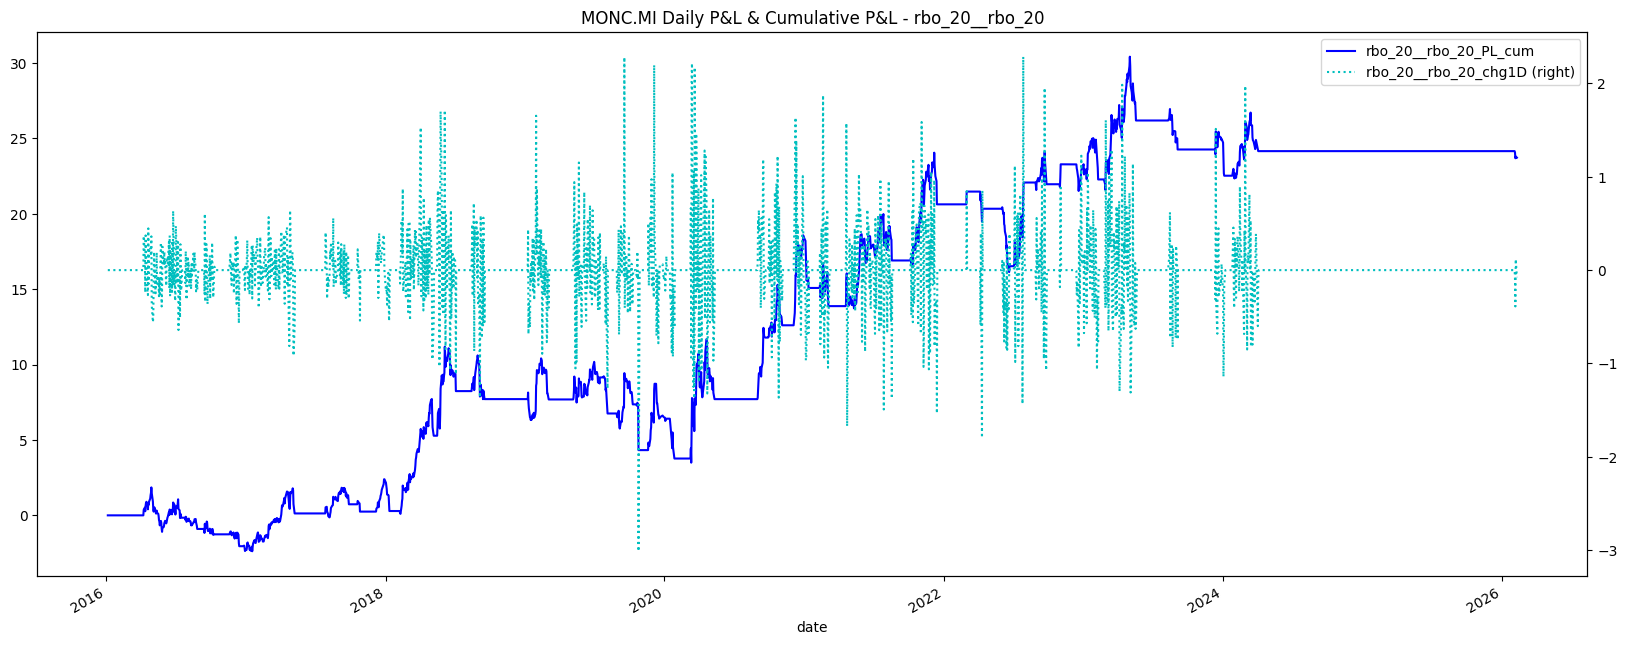

In [29]:
viz.plot_PL(
    df=df,
    ticker=TICKER,
    signal_col=signal_columns[0],

)

---

## 6. Stop Loss Calculation

### StopLossCalculator

**Available Methods:**
| Method | Description |
|--------|-------------|
| `atr_stop_loss` | ATR-based (volatility-adjusted) |
| `fixed_percentage_stop_loss` | Fixed % below/above entry |
| `breakout_channel_stop_loss` | N-day high/low |
| `moving_average_stop_loss` | MA-based stops |
| `volatility_std_stop_loss` | Standard deviation based |

**Stop Loss Logic:**
- Long position: Stop below current price
- Short position: Stop above current price

In [30]:
# =============================================================================
# CALCULATE STOP LOSSES
# =============================================================================
from algoshort.stop_loss import StopLossCalculator

# Initialize calculator
sl_calc = StopLossCalculator(df)

print("Calculating ATR-Based Stop Losses:")
print("=" * 60)

# Calculate ATR stop losses for all signals
for signal in signal_columns:
    df = sl_calc.atr_stop_loss(
        signal=signal,
        window=14,       # ATR lookback period
        multiplier=3.0   # ATR multiplier (higher = wider stops)
    )
    sl_calc.data = df  # Update calculator's data reference

sl_cols = [col for col in df.columns if col.endswith('_stop_loss')]
print(f"\nStop loss columns created: {len(sl_cols)}")

Calculating ATR-Based Stop Losses:

Stop loss columns created: 111


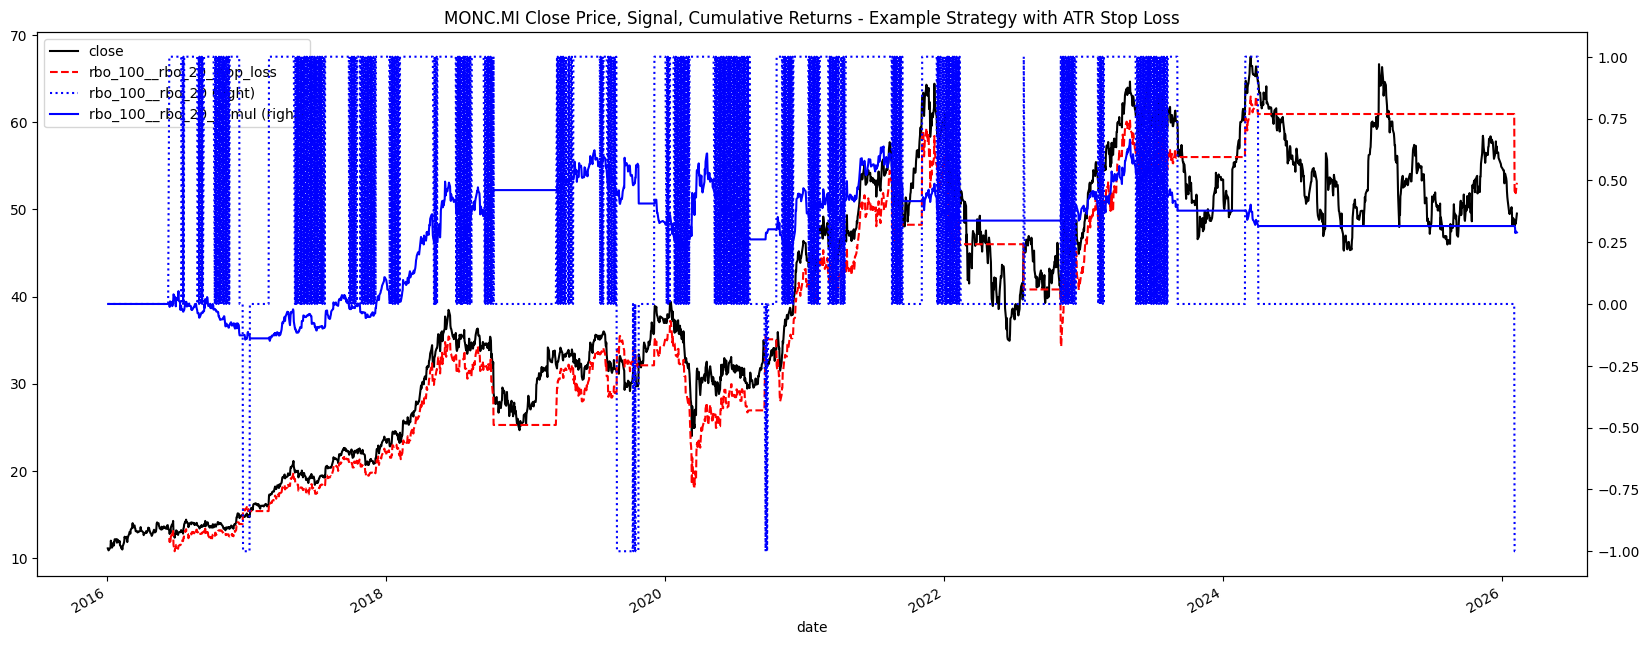

In [46]:
viz.plot_price_signal_cumreturns(
    df=df,
    ticker=TICKER,
    signal_col=signal_columns[20],
    strategy_label="Example Strategy with ATR Stop Loss"
    
)

In [32]:
# =============================================================================
# DEMONSTRATE OTHER STOP LOSS METHODS
# =============================================================================
sample_signal = signal_columns[0]

print(f"\nOther Stop Loss Methods (example for {sample_signal}):")
print("=" * 60)

# Fixed percentage (5%)
print("\n1. Fixed Percentage Stop (5%):")
test_df = sl_calc.fixed_percentage_stop_loss(signal=sample_signal, percentage=0.05)
print(f"   Stop distance: 5% from entry")

# Breakout channel (20-day)
print("\n2. Breakout Channel Stop (20-day):")
test_df = sl_calc.breakout_channel_stop_loss(signal=sample_signal, window=20)
print(f"   Stop at 20-day low (long) / high (short)")

# Moving average (50-day)
print("\n3. Moving Average Stop (50-day):")
test_df = sl_calc.moving_average_stop_loss(signal=sample_signal, window=50)
print(f"   Stop at 50-day MA")

# Volatility (1.5 std dev)
print("\n4. Volatility Stop (1.5 Std Dev):")
test_df = sl_calc.volatility_std_stop_loss(signal=sample_signal, window=20, multiplier=1.5)
print(f"   Stop at 1.5 standard deviations")


Other Stop Loss Methods (example for rbo_20__rbo_20):

1. Fixed Percentage Stop (5%):
   Stop distance: 5% from entry

2. Breakout Channel Stop (20-day):
   Stop at 20-day low (long) / high (short)

3. Moving Average Stop (50-day):
   Stop at 50-day MA

4. Volatility Stop (1.5 Std Dev):
   Stop at 1.5 standard deviations


---

## 7. Position Sizing

### PositionSizing

**Position Sizing Strategies:**

| Strategy | Description | Risk Profile |
|----------|-------------|-------------|
| `equal_weight` | Fixed % of capital | Moderate |
| `constant` | Fixed risk per trade | Moderate |
| `concave` | Reduce risk as drawdown increases | Conservative |
| `convex` | Increase risk when winning | Aggressive |

**Key Formula:**
```
Position Size = (Capital × Risk %) / (Entry Price - Stop Loss)
```

In [33]:
# =============================================================================
# POSITION SIZING
# =============================================================================
from algoshort.position_sizing import PositionSizing, run_position_sizing_parallel

# Initialize position sizer
sizer = PositionSizing(
    tolerance=-0.10,       # Max drawdown tolerance (10%)
    mn=-0.0025,            # Minimum risk per trade (0.25%)
    mx=-0.05,              # Maximum risk per trade (5%)
    equal_weight=0.05,     # Equal weight allocation (5% of capital)
    avg=-0.03,              # Average risk for constant strategy (3%)
    lot=1,                 # Lot size (1 share minimum)
    initial_capital=INITIAL_CAPITAL
)

print(f"Position Sizing Configuration:")
print("=" * 60)
print(f"  Initial Capital: €{INITIAL_CAPITAL:,.0f}")
print(f"  Equal Weight: 5% per position")
print(f"  Risk Range: 0.25% - 5% per trade")
print(f"  Max Drawdown Tolerance: 10%")

print("\nCalculating Position Sizes...")

# Calculate position sizes for all signals in parallel
df = run_position_sizing_parallel(
    sizer=sizer,
    df=df,
    signals=signal_columns,
    chg_suffix="_chg1D_fx",
    sl_suffix="_stop_loss",
    close_col='close',
    n_jobs=-1,
    verbose=5
)

Position Sizing Configuration:
  Initial Capital: €100,000
  Equal Weight: 5% per position
  Risk Range: 0.25% - 5% per trade
  Max Drawdown Tolerance: 10%

Calculating Position Sizes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  91 out of 111 | elapsed:   27.5s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:   30.8s finished


In [34]:
# select date + all equity columns
df_equity = df[['date']].join(df.filter(regex='equity')).tail(1)

# pivot to long format
df_long = df_equity.melt(
    id_vars='date',
    var_name='equity_type',
    value_name='equity_value'
)

df_long["combination_name"] = df_long["equity_type"].str.replace(r"_equity.*$", "", regex=True)
df_long["equity_type"] = df_long["equity_type"].str.replace(r"^.*?_equity_", "", regex=True)

df_long = df_long.merge(results[['combination_name', 'total_trades']], on='combination_name').sort_values("total_trades", ascending=True) .reset_index(drop=True)
df_long

,date,equity_type,equity_value,combination_name,total_trades
0,2026-02-09,convex,99288.7733,rema_100150__rema_100150,11
1,2026-02-09,concave,190604.6497,rema_100150__rema_100150,11
2,2026-02-09,constant,169280.0351,rema_100150__rema_100150,11
3,2026-02-09,equal,104405.9241,rema_100150__rema_100150,11
4,2026-02-09,equal,102609.2492,rbo_100__rbo_100,13
...,...,...,...,...,...
395,2026-02-09,equal,102053.4977,rema_100150__rbo_20,375
396,2026-02-09,convex,99851.0175,rema_50100150__rbo_20,412
397,2026-02-09,concave,138076.3472,rema_50100150__rbo_20,412
398,2026-02-09,constant,135935.0483,rema_50100150__rbo_20,412


In [41]:
# =============================================================================
# EQUITY CURVE ANALYSIS
# =============================================================================
print("\nEquity Curve Summary:")
print("=" * 60)

# Find all equity columns
# equity_cols = [col for col in df.columns if '_equity_equal' in col]
equity_cols = [col for col in df.columns if '_equity_' in col]

# Calculate final equity and returns
equity_results = []
for col in equity_cols:
    signal_name = col.replace('_equity_equal', '')
    final_equity = df[col].iloc[-1]
    total_return = (final_equity / INITIAL_CAPITAL - 1) * 100
    max_equity = df[col].max()
    max_drawdown = (df[col].min() - max_equity) / max_equity * 100
    
    equity_results.append({
        'equity_signal': signal_name,
        'Final Equity': final_equity,
        'Total Return': total_return,
        'Max Drawdown': max_drawdown
    })




Equity Curve Summary:


In [44]:
equity_df = pd.DataFrame(equity_results).sort_values('Final Equity', ascending=False)
equity_df["combination_name"] = equity_df["equity_signal"].str.replace(r"_equity.*$", "", regex=True)
equity_df = equity_df.merge(results[['combination_name', 'total_trades']], on='combination_name').sort_values("Final Equity", ascending=False) .reset_index(drop=True)

print(equity_df.to_string(index=False))

                               equity_signal  Final Equity  Total Return  Max Drawdown             combination_name  total_trades
          rbo_50__rema_100150_equity_concave   215913.8103    115.913810    -59.574644          rbo_50__rema_100150            59
        rtt_5020__rema_100150_equity_concave   209000.8590    109.000859    -57.764254        rtt_5020__rema_100150            59
          rbo_20__rema_100150_equity_concave   200229.7655    100.229766    -60.403088          rbo_20__rema_100150            98
      rsma_50100__rema_100150_equity_concave   199451.5344     99.451534    -57.035409      rsma_50100__rema_100150            40
    rsma_50100__rema_50100150_equity_concave   193042.5119     93.042512    -56.651264    rsma_50100__rema_50100150            44
       rsma_50100__rema_50100_equity_concave   192155.3579     92.155358    -56.651264       rsma_50100__rema_50100            40
              rbo_50__rbo_100_equity_concave   191928.9247     91.928925    -56.952976    

---

## 8. Final Summary

### Complete Analysis Results

In [ ]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("=" * 70)
print(f"FINAL ANALYSIS SUMMARY - {TICKER}")
print("=" * 70)

# Data summary
print(f"\n1. DATA:")
print(f"   Ticker: {TICKER}")
print(f"   Benchmark: {BENCHMARK}")
print(f"   Period: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"   Trading Days: {len(df):,}")

# Performance summary
abs_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
rel_return = (df['rclose'].iloc[-1] / df['rclose'].iloc[0] - 1) * 100
print(f"\n2. BUY & HOLD PERFORMANCE:")
print(f"   Absolute Return: {abs_return:+.2f}%")
print(f"   Relative Return (vs {BENCHMARK}): {rel_return:+.2f}%")

# Best strategy
best_strategy = equity_df.iloc[0]
print(f"\n3. BEST STRATEGY:")
print(f"   Signal: {best_strategy['Signal']}")
print(f"   Total Return: {best_strategy['Total Return']:+.2f}%")
print(f"   Final Equity: €{best_strategy['Final Equity']:,.0f}")

# DataFrame summary
print(f"\n4. DATAFRAME:")
print(f"   Shape: {df.shape}")
print(f"   Memory Usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

# Column breakdown
ohlc_cols = len([c for c in df.columns if c in ['date', 'open', 'high', 'low', 'close', 'fx']])
rel_cols = len([c for c in df.columns if c.startswith('r') and c[1:] in ['open', 'high', 'low', 'close']])
signal_cols_count = len(signal_columns)
return_cols = len([c for c in df.columns if any(k in c for k in ['_chg1D', '_PL_cum', '_returns', '_cumul'])])
sl_cols_count = len([c for c in df.columns if '_stop_loss' in c])
equity_cols_count = len([c for c in df.columns if '_equity_' in c])

print(f"\n5. COLUMNS BREAKDOWN:")
print(f"   OHLC: {ohlc_cols}")
print(f"   Relative OHLC: {rel_cols}")
print(f"   Signals: {signal_cols_count}")
print(f"   Returns: {return_cols}")
print(f"   Stop Losses: {sl_cols_count}")
print(f"   Equity Curves: {equity_cols_count}")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)

FINAL ANALYSIS SUMMARY - ENI.MI

1. DATA:
   Ticker: ENI.MI
   Benchmark: FTSEMIB.MI
   Period: 2016-01-04 to 2026-02-05
   Trading Days: 2,565

2. BUY & HOLD PERFORMANCE:
   Absolute Return: +144.59%
   Relative Return (vs FTSEMIB.MI): +10.68%

3. BEST STRATEGY:
   Signal: rrg
   Total Return: +7.51%
   Final Equity: €107,513

4. DATAFRAME:
   Shape: (2565, 343)
   Memory Usage: 6.71 MB

5. COLUMNS BREAKDOWN:
   OHLC: 6
   Relative OHLC: 4
   Signals: 11
   Returns: 77
   Stop Losses: 11
   Equity Curves: 44

ANALYSIS COMPLETE!


In [ ]:
# =============================================================================
# EXPORT RESULTS (OPTIONAL)
# =============================================================================
# Uncomment the following lines to export results

# Export full DataFrame to CSV
# df.to_csv(f'{TICKER}_analysis.csv', index=False)
# print(f"Results exported to {TICKER}_analysis.csv")

# Export equity summary to CSV
# equity_df.to_csv(f'{TICKER}_equity_summary.csv', index=False)
# print(f"Equity summary exported to {TICKER}_equity_summary.csv")

# Export grid search results to CSV
# results.to_csv(f'{TICKER}_grid_search_results.csv', index=False)
# print(f"Grid search results exported to {TICKER}_grid_search_results.csv")

print("To export results, uncomment the lines above and run this cell.")

To export results, uncomment the lines above and run this cell.
